# Comcast Complaints Text Analytics
In this notebook, we will perform some text analytics on the consumer affairs subset of the [Comcast complaints dataset](https://www.kaggle.com/datasets/archaeocharlie/comcastcomplaints).<br>
We will produce some tables which will be used for producing [this Tableau dashboard](https://public.tableau.com/views/ComcastComplaints/ComcastComplaints?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link).

The target audience of this notebook (and the associated Tableau workbook) are BI specialists.
The goal is to show some useful data you can find in natural language text, and to give BI specialists an idea about a few things we can use to extract and visualize this type of information.

The text analytics we perform here include:
- Basic text analytics like word count and non-stop word count.
- Topic modeling for topics included in the dataset.
- Named entity recognition.

## Environment setup
First things first, we will setup our development environment.
We will import some tools that we will be using throughout the process. We will also be downloading some data and models that will be by those tools.

In [ ]:
%pip install top2vec
%pip install transformers

In [155]:
# import gensim
import nltk
import numpy as np
import os
import pandas as pd
import spacy

# from bertopic import BERTopic

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from torch.utils.data import Dataset
from tqdm import tqdm

from sklearn.metrics import mean_squared_error, accuracy_score

# from tner import TransformersNER
from textblob import TextBlob
from top2vec import Top2Vec

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline

from typing import List, Union

In [4]:
# Make a directory where output files will be saved.
os.makedirs("outputs", exist_ok=True)

In [45]:
# Download some data that will be used by NLTK.
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/zahran/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zahran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zahran/nltk_data...
[nltk_data] Downloading package wordnet to /Users/zahran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [23]:
# Download the en_core_web_lg model for Spacy.
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 1.1 MB/s eta 0:00:0000:0100:08
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [5]:
# Setup the stop_word set, the stemmer and the lemmatizer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

## Data Loading and Preparation
Next, we will load the dataset and prepare it for out text analytics tasks.

### **Before you proceed**:
Please download the [Comcast complaints dataset](https://www.kaggle.com/datasets/archaeocharlie/comcastcomplaints). from Kaggle, extract it, and place it in the current working directory.

In [11]:
# Load the data and display some rows
corpus_df = pd.read_csv('comcast_complaints/comcast_consumeraffairs_complaints.csv')
corpus_df['doc_index'] = corpus_df.index

print(corpus_df.shape)
corpus_df.head(3)

(5659, 5)


,author,posted_on,rating,text,doc_index
0,"Alantae of Chesterfeild, MI","Nov. 22, 2016",1,I used to love Comcast. Until all these consta...,0
1,"Vera of Philadelphia, PA","Nov. 19, 2016",1,I'm so over Comcast! The worst internet provid...,1
2,"Sarah of Rancho Cordova, CA","Nov. 17, 2016",1,If I could give them a negative star or no sta...,2


We can see that the data contains the following columns:
- *author*: This column represents the name of the author of the complaint and their location (city and state).
- *posted_on*: The date when the complaint was posted.
- *rating*: This is a rating assigned by the author to the service they received. It ranges from 0 to 5. We will treat this as some form of sentiment.
- *text*: The text of the complaint submitted by the author.
- *doc_index*: This is the index we created for the complaint in order to be able to perform joins later on the tables we will be creating.

First things first, since we will be doing text analytics, let's make sure we discard any complaints that do not have any text (i.e.: where the text is `null`).

In [12]:
# Discard complaints with null text
corpus_df = corpus_df[corpus_df["text"].notnull()]
print(corpus_df.shape)

(5629, 5)


By comparing the shape of the table before and after discarding null texts, we can see that some complaints did have null text.

Now, during our analysis process, we will be saving portions of the data into separate tables, producing multiple *slim* tables. We can join these tables using the **doc_index** column.<br>
Since we intend to use this data to create visualizations with Tableau, we will find that we don't need the whole data in every single chart we create. Therefore, we will create these slim tables and import them seprately into Tableau, where we will join the tables we need and use them based on the chart we are creating.

Let's save our first table, which will include the **ratings** of the complaints.

In [7]:
# Save a table with the document index and its rating.
corpus_df.to_csv("outputs/out_comcast_ratings.csv", columns=["doc_index", "rating"], index=False)

Next, if we examine the **author** column, we can notice that it includes the location of the author along with its name.<br>
So let's extract the city and the state names and save them into a separate table.

In [8]:
# Extract the city and the state from the author column.
corpus_df[["author name", "location"]] = corpus_df["author"].str.split(" of ", n=1, expand=True)
corpus_df[["city", "state"]] = corpus_df["location"].str.split(', ', n=1, expand=True)
corpus_df.drop(columns=["location", "author name", "author"], inplace=True)
corpus_df.head()

,posted_on,rating,text,doc_index,city,state
0,"Nov. 22, 2016",1,I used to love Comcast. Until all these consta...,0,Chesterfeild,MI
1,"Nov. 19, 2016",1,I'm so over Comcast! The worst internet provid...,1,Philadelphia,PA
2,"Nov. 17, 2016",1,If I could give them a negative star or no sta...,2,Rancho Cordova,CA
3,"Nov. 16, 2016",1,I've had the worst experiences so far since in...,3,Manchester,NH
4,"Nov. 14, 2016",1,Check your contract when you sign up for Comca...,4,Bellevue,WA


In [68]:
# Save location data.
corpus_df.to_csv("outputs/out_comcast_location.csv", columns=["doc_index", "city", "state"], index=False)

## Basic text analysis

Let's start our text analytics work through the very basic stuff. Since Tableau doesn't offer us the ability to perform word-level analysis over a given text, we will extract some useful word-level information (number of words and number of words excluding stop words) and save them in a table.

In [75]:
# Generate text dataframe for basic text analytics
num_words_data = []
num_non_stop_words_data = []

for text in corpus_df["text"]:
    words = text.split()
    num_words = len(words)
    num_non_stop_words = len([w for w in words if w not in stop_words])
    num_words_data.append(num_words)
    num_non_stop_words_data.append(num_non_stop_words)

corpus_df["num_words"] = num_words_data
corpus_df["num_non_stop_words"] = num_non_stop_words_data

corpus_df.to_csv("outputs/out_comcast_text.csv", columns=["doc_index", "text", "num_words", "num_non_stop_words"], index=False)

## Topic Modeling with Top2Vec

Now let's get into the real stuff.

When we looked at the data, we saw that we had a bunch of complaints, combined with information like the date of the complaint, the author, their location, and the rating they gave.<br>
However, we had no classification of the complaints, and we don't know what specific topics are included therein.

In order to extract this type of information, we can use *topic modeling*.

The Wikipedia definition of a topic model is:
> A type of statistical model for discovering the abstract "topics" that occur in a collection of documents.

Jurafsky and Martin describe what topic models do as:
> apply unsupervised learning on large sets of texts to induce sets of associated words from text.
>
> *(From Jurafsky and Martin's Speech and Language Processing (3rd Edition Draft as of March 3, 2023), p. 106)*

We will be using a very nice tool for topic modeling called *[Top2Vec](https://github.com/ddangelov/Top2Vec)*.

Top2vec requires minimal effort to run. It doesn't even require text pre-processing. It does this stuff on its own. Furthermore, it gives really good results.

However, this model is really non-deterministic. This means that every time you run it, it can give different outputs.<br>
Therefore, I saved the model I got from Top2vec so that you can go through the same workflow in this notbook. You can find this model [here](https://drive.google.com/file/d/1kFIzJxhE4VUTIXJj57sXglNB0CVI4i3v/view?usp=share_link).

So if you would like to go along with the notebook and get the exact same results:

1. skip the next cell (where the model is being created)
2. download the model in the link above
3. Place the model in your working directory
4. continue from the cell afterwards (where the model is being loaded).

Otherwise, you can proceed directly from the next step.

In [7]:
# Create and save the topic model.
model = Top2Vec(corpus_df["text"].tolist(), ngram_vocab=True, speed="deep-learn", workers=8)
model.save("comcast_complaints_top2vec_model")

2023-02-26 00:18:59,982 - top2vec - INFO - Pre-processing documents for training
2023-02-26 00:19:02,053 - top2vec - INFO - Creating joint document/word embedding
2023-02-26 00:24:26,812 - top2vec - INFO - Creating lower dimension embedding of documents
2023-02-26 00:24:40,804 - top2vec - INFO - Finding dense areas of documents
2023-02-26 00:24:41,014 - top2vec - INFO - Finding topics


In [4]:
# Load the created model.
model = Top2Vec.load("comcast_complaints_top2vec_model")

Now let's examine the topic model. In the next two cells, we will print the number of topics and the number of documents associated with each topic.

In [8]:
# Display the number of topics in the model.
model.get_num_topics()

28

In [11]:
# Print the number of documents assigned by the model to each topic.
topic_sizes, topic_nums = model.get_topic_sizes()
print(topic_sizes)

[634 610 481 385 383 378 249 246 201 185 180 154 145 143 140 131 125 120
 117 101  89  70  70  69  65  59  50  49]


Here, we see that the model has 28 topics, sorted by Top2vec descendingly based on how many documents are associated with them.

Let's have a deeper look into these topics through examining the terms associated with each topic.

In [7]:
# Get the terms and indices of each topic in the model.

topic_words, word_scores, topic_nums = model.get_topics()
for words, scores, num in zip(topic_words, word_scores, topic_nums):
    print(num)
    print(f"Words: {words}")

0
Words: ['amount owed' 'monthly payment' 'collection' 'money hungry' 'due balance'
 'make payment' 'already paid' 'owe them' 'due amount' 'owed'
 'collection notice' 'payment arrangements' 'saying owe'
 'remaining balance' 'payment arrangement' 'unpaid balance'
 'collection notices' 'collection agency' 'balance' 'agency'
 'final balance' 'being ripped' 'credit report' 'tap being'
 'collections agency' 'bank statement' 'past due' 'account holder'
 'received letter' 'bulk account' 'bank' 'credit score' 'bank account'
 'credit bureaus' 'credit rating' 'payment' 'credit cards'
 'credit reporting' 'due date' 'sent refresh' 'kept saying'
 'statement showing' 'billing statement' 'kept getting' 'letter stating'
 'collections' 'paid' 'still unresolved' 'kept asking' 'made priority']
1
Words: ['ve ever' 'worst company' 'ever encountered' 'worst customer'
 'worst enemy' 'don want' 'didn want' 'how much' 'worst experience'
 'know how' 'every month' 'terrible experience' 'money hungry'
 'go elsewh

We can notice that each topic has some associated terms that make sense to be placed together, and some that seem out of context.

For example, the first topic (at index 0) seems to be talking about money and payment. Most of the terms are money-related.

Terms that make sense within that topic include:
- "amount owed"
- "monthly payment"
- "money hungry"

Other terms that seem out of context include:
- "kept saying"
- "kept getting"
- "kept asking"

This is because these topics are abstract topics that depend mainly on the co-occurrence of those terms in the dataset. So it seems like the model associated two topics together, the first being the topic of money, and the second being the topic of constantly asking for something. This produced an abstract machine-generated topic which is dominated by the money-related topic.

We can now come up with names for these topics. These names can be manual annotations done by human experts, or directly assigned by noticing the most tightly-associated terms with each topic, or even machine-generated using generative models. A useful tool that can help us come up with manual topic names would be to look at the word cloud generated by Top2Vec.

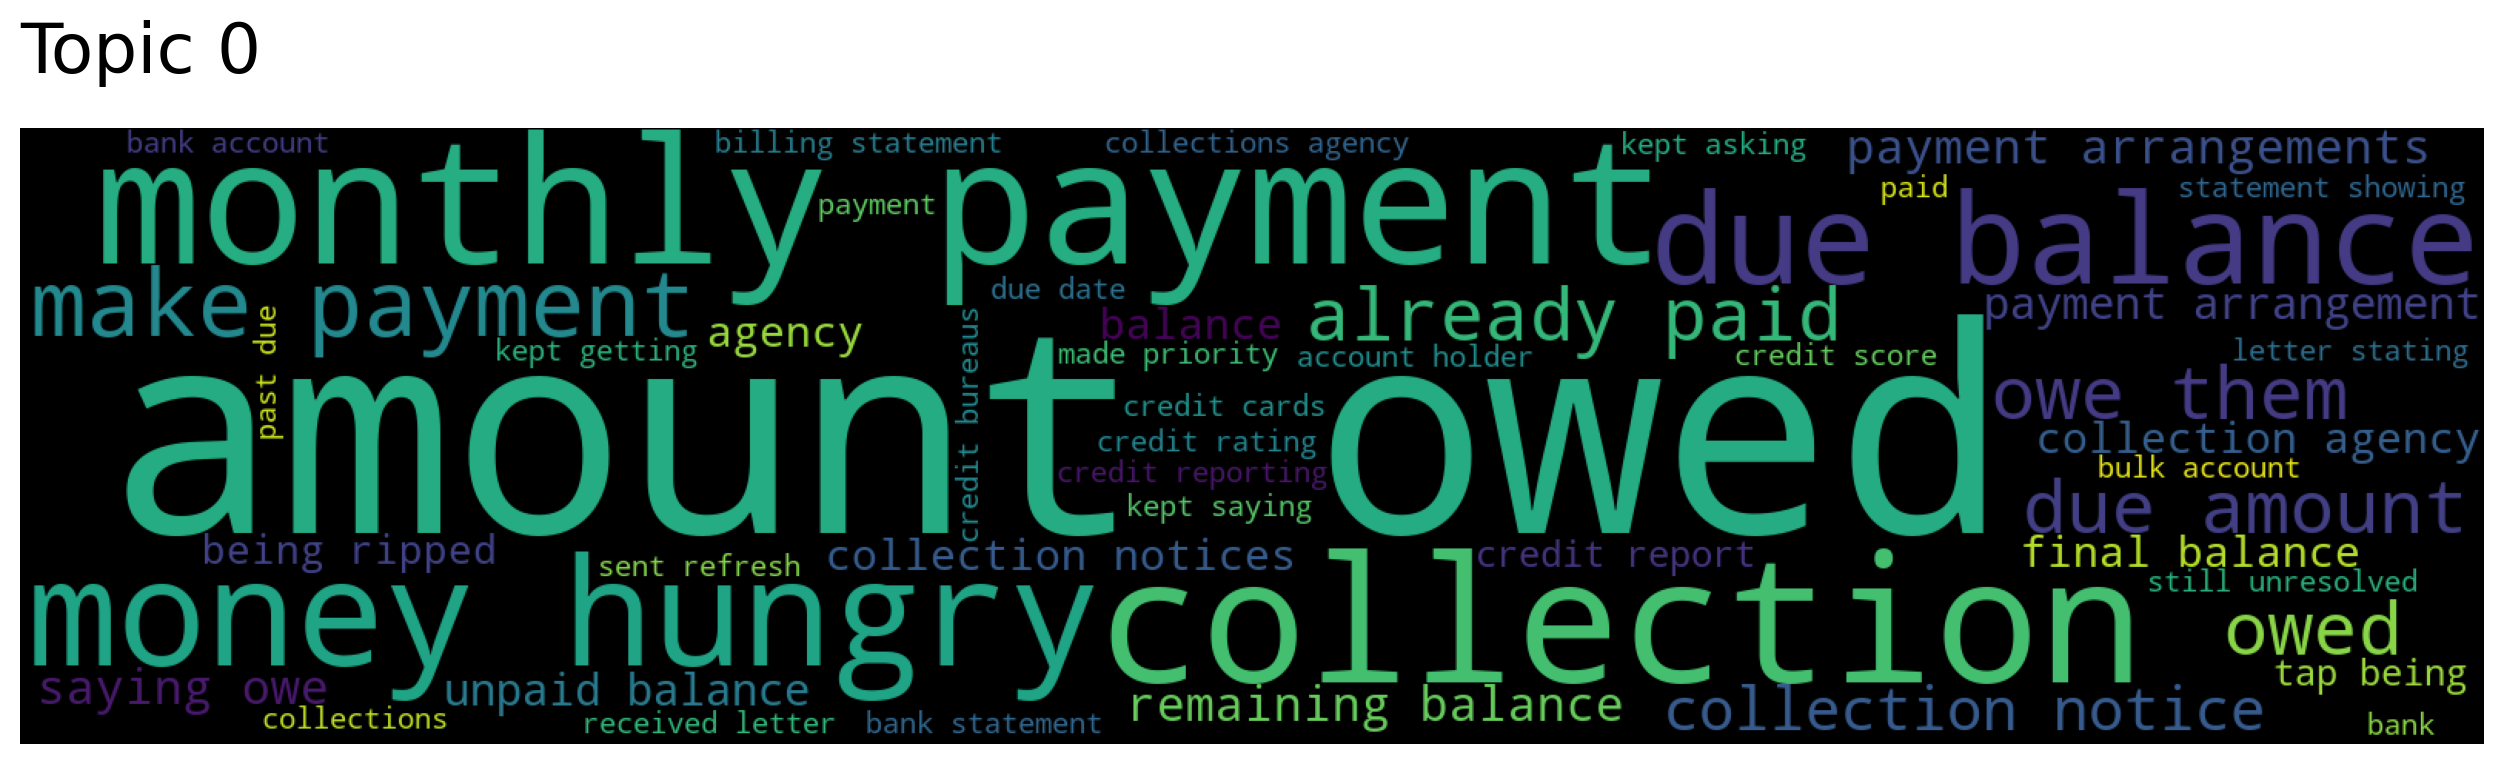

In [8]:
# Generate a word cloud for the first topic.
model.generate_topic_wordcloud(topic_nums[0])

It looks evident that this topic is talking about money, since all the bug words are related to money and payments.

Now let's save the results we obtained from this model.

In [63]:
# Save the topics for each document.
document_topics = model.get_documents_topics(doc_ids=list(range(corpus_df.shape[0])))[0].tolist()
corpus_df["document_topic"] = document_topics
corpus_df.to_csv("outputs/out_comcast_topics.csv", columns=["doc_index", "document_topic"], index=False)

## Topic Label Generation

In many cases, manually annotating topic names can be impractical. If we don't like giving our topics long names by appending associated topics, one method we can use is topic label generation.

Topic label generation is not mature enough yet, but it can come up with interesting results based on the input.

Here, we will try to automate the process of label generation by using the [bart-tl-ng](https://huggingface.co/cristian-popa/bart-tl-ng) model.<br>
This model is generative. It does not select a label from a pool of keywords. It looks at the given terms and generates a label that suits them.

In [47]:
# Load the topic label generation model.
mname = "cristian-popa/bart-tl-ng"
tokenizer = AutoTokenizer.from_pretrained(mname)
auto_topic_labeling_model = AutoModelForSeq2SeqLM.from_pretrained(mname)

In [48]:
# Generate topic labels for each topic.
topic_words_joined = ' '.join(topic_words[0].tolist())
enc = tokenizer(topic_words_joined, return_tensors="pt", truncation=True, padding="max_length", max_length=256)
outputs = auto_topic_labeling_model.generate(
    input_ids=enc.input_ids,
    attention_mask=enc.attention_mask,
    max_length=15,
    min_length=1,
    do_sample=False,
    num_beams=25,
    length_penalty=1.0,
    repetition_penalty=1.5
)
decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f'BART-TL-NG generated label "{decoded}" for the topic with keywords {topic_words[0].tolist()}')

BART-TL-NG generated label "interest rate" for the topic with keywords ['amount owed', 'monthly payment', 'collection', 'money hungry', 'due balance', 'make payment', 'already paid', 'owe them', 'due amount', 'owed', 'collection notice', 'payment arrangements', 'saying owe', 'remaining balance', 'payment arrangement', 'unpaid balance', 'collection notices', 'collection agency', 'balance', 'agency', 'final balance', 'being ripped', 'credit report', 'tap being', 'collections agency', 'bank statement', 'past due', 'account holder', 'received letter', 'bulk account', 'bank', 'credit score', 'bank account', 'credit bureaus', 'credit rating', 'payment', 'credit cards', 'credit reporting', 'due date', 'sent refresh', 'kept saying', 'statement showing', 'billing statement', 'kept getting', 'letter stating', 'collections', 'paid', 'still unresolved', 'kept asking', 'made priority']


The generated label seems creative. However, from our knowledge of the data, it seems like it does not reflect the actual topic. Therefore, we will resort to the manual method for our usecase.

# Named Entity Recognition

One of the most important and well-known tasks in natural language processing (NLP) is the task of named entity recognition (NER).

Wikipedia defines the task of NER as follows:
> Named-entity recognition (NER) (also known as (named) entity identification, entity chunking, and entity extraction) is a subtask of information extraction that seeks to locate and classify named entities mentioned in unstructured text into pre-defined categories such as person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc.

Jurafsky and Martin define it as follows:
> The task of named entity recognition (NER) is to find spans of text that constitute proper names and tag the type of the entity.
>
> *(From Jurafsky and Martin's Speech and Language Processing (3rd Edition Draft as of March 3, 2023), p. 165)*

This task is covered by lots of models and libraries. We will examine two of them: *[Spacy](https://spacy.io/)* (an open-source Python library) and *[RoBERTA Large NER English](https://huggingface.co/Jean-Baptiste/roberta-large-ner-english)* (a standalone model).

Let's start with Spacy.

In [9]:
# Load Spacy's model
ner_model = spacy.load("en_core_web_lg")

In [14]:
# Perform NER for a sample complaint.
print(corpus_df["text"][0])
doc = ner_model(corpus_df["text"][0])
[(x.text,x.label_) for x in doc.ents]

I used to love Comcast. Until all these constant updates. My internet and cable crash a lot at night, and sometimes during the day, some channels don't even work and on demand sometimes don't play either. I wish they will do something about it. Because just a few mins ago, the internet have crashed for about 20 mins for no reason. I'm tired of it and thinking about switching to Wow or something. Please do not get Xfinity.


[('Comcast', 'ORG'),
 ('night', 'TIME'),
 ('the day', 'DATE'),
 ('just a few mins ago', 'TIME'),
 ('about 20 mins', 'TIME'),
 ('Xfinity', 'ORG')]

We can see that Spacy is fast and produces very good results. However, it couldn't capture all the named entity "Wow" (an internet service provider).

Now let's try the RoBERTa Large NER English model.

In [15]:
# Load the tokenizer and the RoBERTA Large NER model and create a NER pipeline.
tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/roberta-large-ner-english")
ner_model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/roberta-large-ner-english")
ner_pipeline = pipeline("ner", model=ner_model, tokenizer=tokenizer, aggregation_strategy="simple")

In [16]:
# Run the NER pipeline on a sample complaint.
print(corpus_df["text"][0])
print(ner_pipeline(corpus_df["text"][0]))

I used to love Comcast. Until all these constant updates. My internet and cable crash a lot at night, and sometimes during the day, some channels don't even work and on demand sometimes don't play either. I wish they will do something about it. Because just a few mins ago, the internet have crashed for about 20 mins for no reason. I'm tired of it and thinking about switching to Wow or something. Please do not get Xfinity.
[{'entity_group': 'ORG', 'score': 0.997343, 'word': ' Comcast', 'start': 15, 'end': 22}, {'entity_group': 'ORG', 'score': 0.9864456, 'word': ' Wow', 'start': 381, 'end': 384}, {'entity_group': 'ORG', 'score': 0.9774347, 'word': ' Xfinity', 'start': 417, 'end': 424}]


The RoBERTa Large NER English model was able to capture the named entity "Wow". It takes more time though, and ignores dates and times.

Since we are very interested in organization names and stuff like that for our analysis of the complaints, we will go with this model.

**Warning**: The following cell takes a long time to run.

In [59]:
# Run the NER pipeline on the dataset.
ner_results = []
texts = corpus_df["text"].tolist()

class TextDataset(Dataset):
    def __init__(self, dataset_texts) -> None:
        super().__init__()
        self.texts = dataset_texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, i):
        return self.texts[i]

texts_dataset = TextDataset(texts)
for out in tqdm(ner_pipeline(texts_dataset), total=len(texts_dataset)):
    ner_results.append(out)

# ner_results = ner_pipeline(corpus_df["text"].tolist())

100%|██████████| 5629/5629 [6:01:41<00:00,  3.86s/it]  


Let's save the results from this model.

In [67]:
# Save the named entity results for the dataset.
named_entities = []
for doc_index, ner_result in enumerate(ner_results):
    for entity in ner_result:
        named_entities.append((doc_index, entity['entity_group'], entity['word'].strip()))

named_entities_df = pd.DataFrame(named_entities, columns=["doc_index", "entity_group", "entity_text"])
named_entities_df.to_csv("outputs/out_comcast_entities.csv", index=False)

# Sentiment Analysis

This is another very well-known task in NLP.

Wikipedia defines sentiment analysis as follows:
> Sentiment analysis (or opinion mining) is a natural language processing (NLP) technique used to determine whether data is positive, negative or neutral.

Jurafsky and Martin define it as:
> the extraction of sentiment, the positive or negative orientation that a writer expresses toward some object.
>
> *(From Jurafsky and Martin's Speech and Language Processing (3rd Edition Draft as of March 3, 2023), p. 58)*

Since we already have a rating column in our data, we can treat it as a sentiment. However, we can run sentiment analysis and compare the results with the ratings we have.<br>
Given that these are complaints, we should expect that they will be mostly negative. Therefore, we are really interested in measuring the correlation between the ratings and the predicted sentiments.

We will be using TextBlob to perform sentiment analysis.

Let's run sentiment analysis on a sample complaint.

In [22]:
# Run TextBlob sentiment analysis on a sample complaint.
TextBlob(corpus_df["text"][0]).sentiment

Sentiment(polarity=-5.551115123125783e-18, subjectivity=0.5466666666666666)

The result contains two numbers:
- *polarity*: a number on a scale from -1 to 1, where 1 represents positive sentiment, and -1 represents negative sentiment.
- *subjectivity*: a number on a scale from 0 to 1, which represents how much the model thinks the author of the text is not biased by their personal opinion, where 1 represents an unbiased statement.

Now let's do sentiment analysis over the whole dataset.

In [104]:
# Run TextBlob sentiment analysis on the whole dataset.
text_blob_sentiment_results = []

for text in corpus_df["text"]:
    sentiment = TextBlob(text).sentiment.polarity
    text_blob_sentiment_results.append(sentiment)

We can now measure metrics like the mean squared error (MSE) and the Pearson correlation coefficient (PCC) between the predicted scores and the original ratings.

In [117]:
# Convert predicted scores and original ratings to NumPy array to calculate PCC.
text_blob_sentiment_results_np = np.array(text_blob_sentiment_results)
ratings_np = corpus_df["rating"].to_numpy()

print(f"PCC: {np.corrcoef(text_blob_sentiment_results_np, ratings_np)[0][1]}")

# Scale predicted scores and original ratings to a range from 0 to 1 to compute MSE.
rescaled_ratings_np = ratings_np / 5
rescaled_text_blob_sentiment_results_np = (text_blob_sentiment_results_np + 1) / 2

print(f"MSE: {mean_squared_error(rescaled_text_blob_sentiment_results_np, rescaled_ratings_np)}")

PCC: 0.030990422556398563
MSE: 0.13183959761546932


It appears that the correlation is low although the mean squared error is not that high.
Let's try another model that is supposed to perform better on negative sentiment.

In [120]:
# Load the Vader sentiment analysis model.
vader_sentiment_model = SentimentIntensityAnalyzer()

In [121]:
# Perform sentiment analysis with Vader on a sample complaint.
vader_sentiment_model.polarity_scores(corpus_df["text"][0])

{'neg': 0.153, 'neu': 0.731, 'pos': 0.116, 'compound': -0.0757}

The output of Vader's sentiment model includes probability scores for the sentiment being negative, positive, or neutral.<br>
It also includes a *compound score* that ranges from -1 to 1.

Let's run it on the whole dataset.

In [122]:
# Perform sentiment analysis with Vader on the whole dataset.
vader_sentiment_results = []
for text in corpus_df["text"]:
    sentiment = vader_sentiment_model.polarity_scores(text)["compound"]
    vader_sentiment_results.append(sentiment)

Now let's measure the same metrics for Vader.

In [124]:
# Compute PCC and MSE for the Vader sentiment analysis results.
vader_sentiment_results_np = np.array(vader_sentiment_results)
print(f"PCC: {np.corrcoef(vader_sentiment_results_np, ratings_np)[0][1]}")
rescaled_vader_sentiment_results_np = (vader_sentiment_results_np + 1) / 2
print(f"MSE: {mean_squared_error(rescaled_vader_sentiment_results_np, rescaled_ratings_np)}")


PCC: 0.08078835251467804
MSE: 0.14596380665437914


Although the MSE is a bit higher, the correlation is in fact stronger.
Let's have a close look at one of the examples where the model is unable to predict the correct sentiment.

In [132]:
# Print sentiment analysis results for a sample complaint.
print(f"Complaint: {corpus_df['text'][4]}")
print(f"Predicted rating: {vader_sentiment_results[4]}, actual rating: {corpus_df['rating'][4]}")

Complaint: Check your contract when you sign up for Comcast as their advertised offers do not match the contract they issue. I signed up for $49.99 150Mbps internet for 2 years, however my contract has $19.99 for 25Mbps internet for 2 years. They say there is an add on in place for $30 which boost it to Blast! Pro, however this isn't part of the contract, which means that Comcast can increase the price whenever they want within the 2 years. This means I haven't received the advertised rate. Comcast has so far refused to issue corrected contract, or issue in writing that the $30 will remain at that price for 2 years. I just have to trust them. So watch out, Comcast is doing the usual illegal practices, I'm guessing to catch people out and hope they don't notice and end up paying more than they should.
Predicted rating: 0.6921, actual rating: 1


It appears that although this document has a rating of 1/5, it was given a high sentiment score. This may be due to the lack of terms that are generally associated with negative sentiment.

Now let's try a more advanced model that is built for sentiment analysis on reviews.

N.B.: This model can only take documents up to 512 tokens as input, so we will resort to taking the first 512 tokens using the `truncation` argument to the pipeline.

In [86]:
# Load the Amazon Review Sentiment Analysis model.
sentiment_model_tokenizer = AutoTokenizer.from_pretrained("LiYuan/amazon-review-sentiment-analysis")
sentiment_model = AutoModelForSequenceClassification.from_pretrained("LiYuan/amazon-review-sentiment-analysis")
sentiment_pipeline = pipeline("text-classification", model=sentiment_model, tokenizer=sentiment_model_tokenizer)

In [90]:
# Run sentiment analysis using the Amazon Review Sentiment Analysis model for a sample complaint.
print(texts[10])
print(sentiment_pipeline(texts[10], truncation="only_first"))

Had them from 2014 to now. I'd tell new customers to run but there is nowhere to run to. I tried, but it turned out Comcast was Xfinity. Signing up for a contract has no meaning. The fine print in the contract that they suggest you read when they randomly change a contract says they can change anything anytime and are not doing anything wrong. I disagree. I have or had performance pro, paying for a speed of internet a month under a contract. Not month to month alone. The speed is not listed or told to you just it's between 25 and 50.I got a letter Friday saying Tue (today) I'm being forced into a new contract plan. I'm now paying for my data at the same speed with a cap of a terabyte. Seems like a lot but it's not and not what I signed up for. But all customer service says is that's the deal now. They don't offer plans by just speed it's changed. Those who use more Internet should pay more. It's not fair to the other customers. What does it matter fair it's what we signed up to use. I 

The labels this model produces are in the format `X star(s)` (e.g.: `1 star`, `2 stars`, etc.), so we will have to extract the number from the produced output.

Let's run the model on the whole dataset.

**Warning**: The following cell takes a long time to run.

In [98]:
# Run sentiment analysis using the Amazon Review Sentiment Analysis model on the whole dataset.
sentiment_results = []
texts = corpus_df["text"].tolist()
batch_size=2

class TextDataset(Dataset):
    def __init__(self, dataset_texts) -> None:
        super().__init__()
        self.texts = dataset_texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, i):
        return self.texts[i]

texts_dataset = TextDataset(texts)
for out in tqdm(sentiment_pipeline(texts_dataset, truncation="only_first"), total=len(texts_dataset)):
    sentiment_results.append(out)

100%|██████████| 5629/5629 [1:50:04<00:00,  1.17s/it]  


In [101]:
# Process the results to extract the rating.
processed_sentiment_results = []

for sentiment_result in sentiment_results:
    processed_sentiment_results.append(int(sentiment_result["label"][0]))

In [128]:
# Compute PCC and MSE for the produced results.
liyuan_sentiment_results_np = np.array(processed_sentiment_results)
print(f"PCC: {np.corrcoef(liyuan_sentiment_results_np, ratings_np)[0][1]}")

rescaled_liyuan_sentiment_results_np = (liyuan_sentiment_results_np - 1) / 4
print(f"MSE: {mean_squared_error(rescaled_liyuan_sentiment_results_np, rescaled_ratings_np)}")


PCC: 0.08546989148995719
MSE: 0.1088887901936401


This one obtains the least MSE and the highest PCC. However, the numbers are far from satisfactory.

In [102]:
# Save the sentiment analysis results for the dataset.
corpus_df["predicted_rating"] = processed_sentiment_results
corpus_df.to_csv("outputs/out_comcast_predicted_rating.csv", columns=["doc_index", "predicted_rating"], index=False)

Does this imply that the domain of sentiment analysis is completely useless? Of course not.

Let's try to binarize the output of the models we just examined and compute the regular accuracy score.

In [166]:
textblob_acc = accuracy_score(rescaled_text_blob_sentiment_results_np <= 0.5, rescaled_ratings_np_binary)
vader_acc = accuracy_score(rescaled_vader_sentiment_results_np <= 0.5, rescaled_ratings_np_binary)
liyuan_acc = accuracy_score(rescaled_liyuan_sentiment_results_np <= 0.5, rescaled_ratings_np_binary)

print(f"TextBlob accuracy: {textblob_acc}")
print(f"Vader accuracy: {vader_acc}")
print(f"Amazon Reviews Sentiment Analysis model accuracy: {liyuan_acc}")

TextBlob accuracy: 0.5114585183869248
Vader accuracy: 0.7173565464558536
Amazon Reviews Sentiment Analysis model accuracy: 0.8889678450879375


It appears that when doing binary classification, we get more accurate results. This maybe due to the subjective nature of reviews. Some users tend to give only 1's and 5's, others tend to give ratings in between, which makes it very hard to produce an accurate rating.